In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


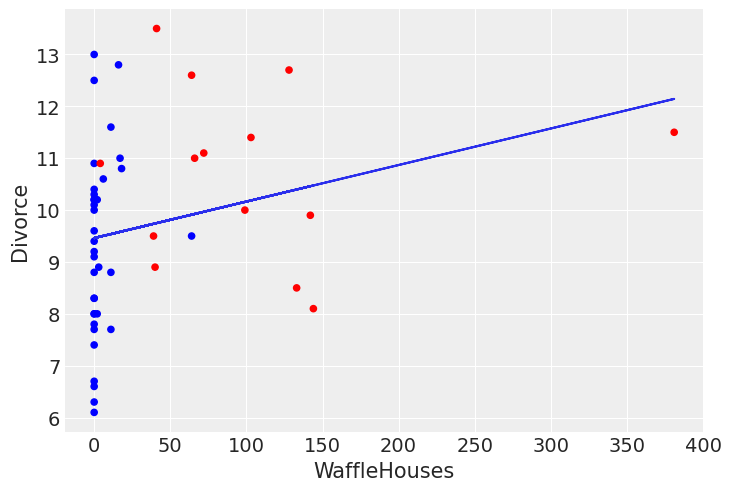

In [4]:
x = df_waf['WaffleHouses']
y = df_waf['Divorce']

colors = df_waf['South'].apply(lambda x: 'r' if x == 1 else 'b')

# Fit the data to a line using polyfit
m, c = np.polyfit(x, y, 1)

# Plot both the line and the original data
_, ax = plt.subplots(1, 1)
ax.plot(x, m * x + c)

df_waf.plot.scatter(x='WaffleHouses', y='Divorce', marker='o', c=colors, ax=ax)

plt.show()

### Code 5.1 Standardize Variables

In [5]:
age = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
divorce = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
marriage = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## The Model: Divorce Rate vs Median Age

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
np.std(df_waf['Divorce']), np.std(df_waf['MedianAgeMarriage'])

(1.8025138002245642, 1.231131187160816)

### The Priors

Since both $D_i$ and $A_i$ are standardized, we would expect $\alpha \approx 0$. Thus we may use an even smaller standard deviation value than $0.2$ for the prior of $\alpha$. If $\beta_A = 1$, then a one standard deviation change at the median age of marriage results in a change of one standard deviation in the divorce rate. The prior $\beta_A \sim N(0, 0.5)$ places only $5\%$ probability of that happening.    

### Code 5.3

In [7]:
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_A * age)
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


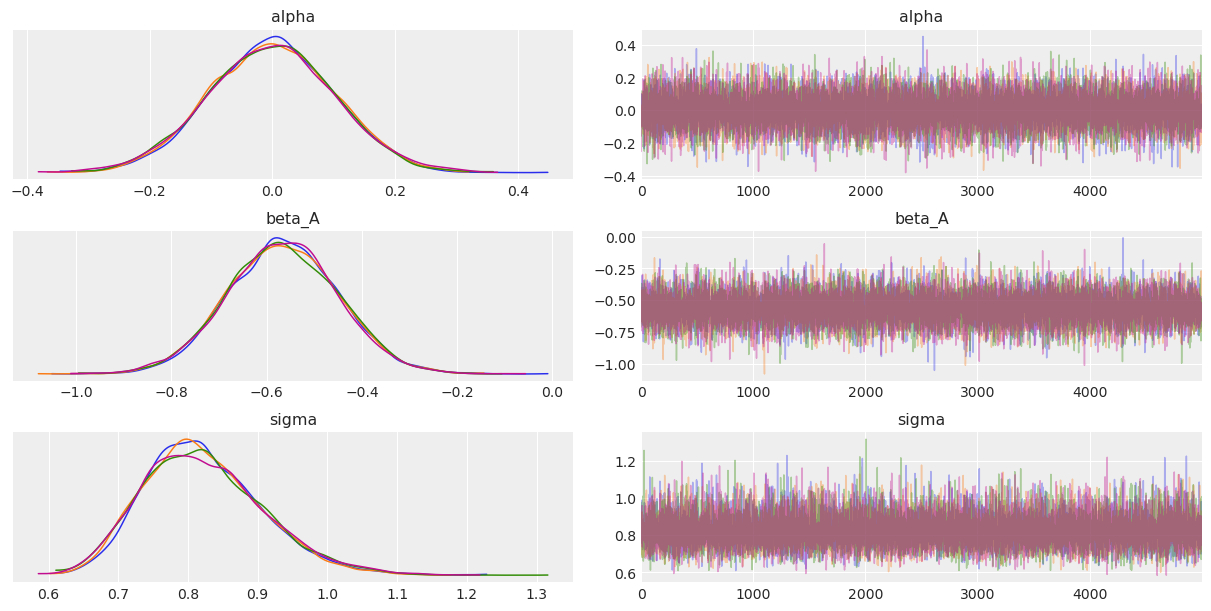

In [8]:
az.plot_trace(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'])

plt.show()

In [9]:
df_tr_5_1 = pm.trace_to_dataframe(trace_5_1)
df_tr_5_1.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.057759,-0.630563,0.757836,0.440063,0.490766,0.186546,0.947097,-0.320488,0.237249,-0.726115,...,0.287953,0.490766,0.490766,1.454130,-0.371191,-0.117675,0.135842,0.592173,-0.066971,0.997800
1,-0.090177,-0.542695,0.816378,0.238853,0.282491,0.020663,0.675233,-0.415717,0.064301,-0.764821,...,0.107939,0.282491,0.282491,1.111613,-0.459355,-0.241165,-0.022975,0.369767,-0.197527,0.718871
2,0.057916,-0.627969,0.783439,0.438647,0.489141,0.186173,0.943595,-0.318776,0.236667,-0.722734,...,0.287162,0.489141,0.489141,1.448543,-0.369271,-0.116796,0.135678,0.590131,-0.066302,0.994090
3,-0.058399,-0.463523,0.988156,0.222630,0.259901,0.036271,0.595347,-0.336446,0.073543,-0.634620,...,0.110814,0.259901,0.259901,0.968064,-0.373718,-0.187359,-0.001001,0.334445,-0.150088,0.632619
4,-0.040641,-0.405099,0.779283,0.204966,0.237540,0.042097,0.530705,-0.283642,0.074671,-0.544233,...,0.107245,0.237540,0.237540,0.856444,-0.316216,-0.153346,0.009523,0.302688,-0.120773,0.563279


In [10]:
df_mu_5_1 = df_tr_5_1.filter(regex=('mu.*'))
mu_mean = df_mu_5_1.apply(np.mean, axis=0)

In [11]:
mu_mean.values.shape

(50,)

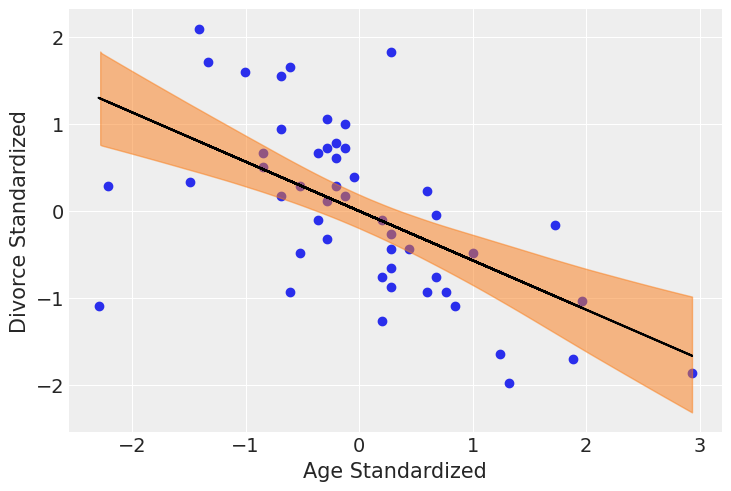

In [12]:
_, ax = plt.subplots(1, 1)
ax.scatter(age, divorce, marker='o')

ax.plot(age, mu_mean, 'k')

az.plot_hdi(age, np.expand_dims(df_mu_5_1.values, 0), ax=ax)

ax.set_xlabel('Age Standardized')
ax.set_ylabel('Divorce Standardized')

plt.show()

## Prior Predictive Plots

### Code 5.4

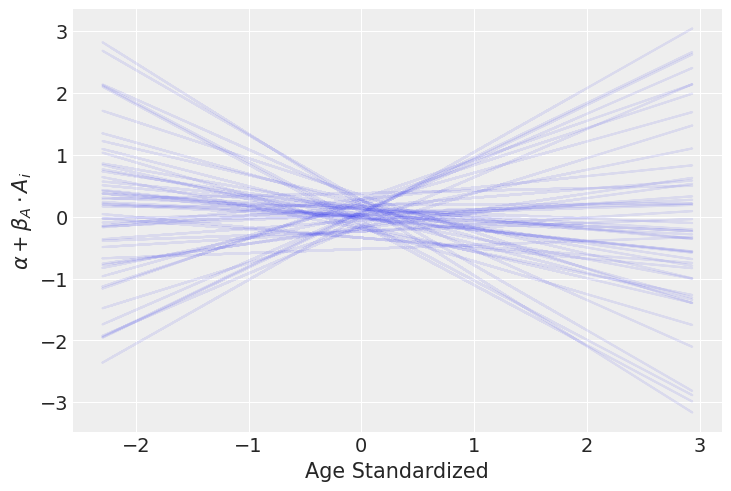

In [13]:
from scipy.stats import norm


N = 50 
alpha_vals = norm.rvs(loc=0, scale=0.2, size=N)
beta_vals = norm.rvs(loc=0, scale=0.5, size=N)

_, ax = plt.subplots(1, 1)
ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\alpha + \beta_A \cdot A_i$')

for i in range(N):
    alpha_i = alpha_vals[i]
    beta_i = beta_vals[i]
    
    mu_values = [alpha_i + beta_i * a for a in age]
    
    ax.plot(age, mu_values, color='C0', alpha=0.1)

plt.show()

## Posterior Plots

Since PyMC3 already includes the posterior samples in the trace, we really don't have to do anything more.

### Code 5.5

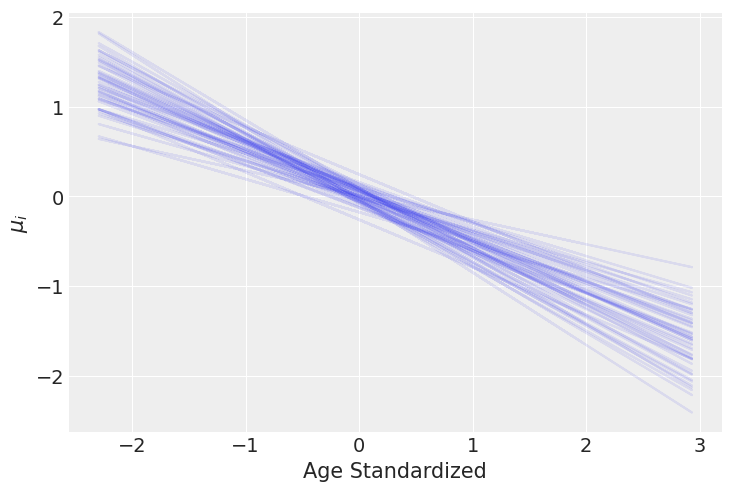

In [14]:
df_mu_T = df_mu_5_1.T

sample = np.random.choice(range(0, 20000), size=50)

_, ax = plt.subplots(1, 1)
ax.plot(age, df_mu_T.loc[:, sample], color='C0', alpha=0.1)

ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\mu_i$')

plt.show()

## The Model: Divorce Rate vs Marriage Rate

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_M \cdot M_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.6

In [15]:
with pm.Model() as m_5_2:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * marriage)
    D_2 = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_2 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 6 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


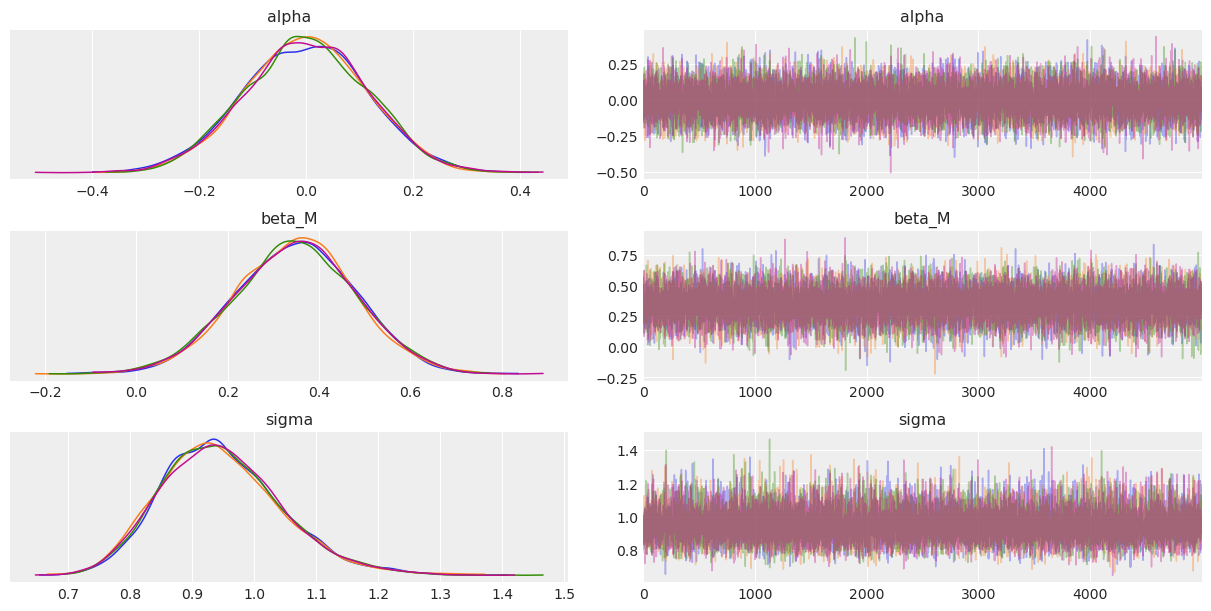

In [16]:
az.plot_trace(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'])

plt.show()

In [17]:
df_tr_5_2 = pm.trace_to_dataframe(trace_5_2)
df_mu_2 = df_tr_5_2.filter(regex='(mu.*)')

df_mu_2.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.066163,0.749657,0.077948,0.796794,-0.063465,0.455048,-0.299152,0.407910,-0.228446,-0.310937,...,0.054379,-0.028112,0.219360,1.173894,-0.381643,0.101516,0.207576,0.301851,-0.287368,1.303523
1,-0.071697,0.313295,-0.065059,0.339846,-0.144712,0.147350,-0.277468,0.120799,-0.237641,-0.284106,...,-0.078335,-0.124799,0.014594,0.552255,-0.323933,-0.051783,0.007957,0.061059,-0.270830,0.625271
2,0.143142,0.764044,0.153847,0.806864,0.025385,0.496414,-0.188719,0.453593,-0.124488,-0.199424,...,0.132437,0.057500,0.282310,1.149431,-0.263656,0.175258,0.271604,0.357246,-0.178014,1.267188
3,-0.128512,0.330115,-0.120604,0.361745,-0.215492,0.132431,-0.373640,0.100802,-0.326196,-0.381547,...,-0.136419,-0.191770,-0.025716,0.614780,-0.428991,-0.104789,-0.033623,0.029636,-0.365732,0.701761
4,-0.009142,0.285917,-0.004055,0.306266,-0.065101,0.158737,-0.166846,0.138388,-0.136322,-0.171933,...,-0.014229,-0.049840,0.056992,0.469057,-0.202456,0.006120,0.051905,0.092603,-0.161758,0.525016


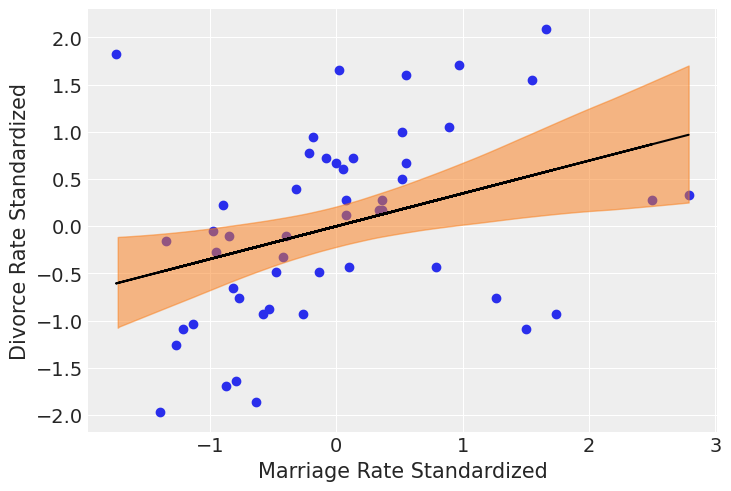

In [18]:
mu_mean_2 = df_mu_2.apply(np.mean, axis=0)

_, ax = plt.subplots(1, 1)
ax.scatter(marriage, divorce, marker='o')

ax.plot(marriage, mu_mean_2, 'k')

az.plot_hdi(marriage, np.expand_dims(df_mu_2.values, 0), ax=ax)

ax.set_xlabel('Marriage Rate Standardized')
ax.set_ylabel('Divorce Rate Standardized')

plt.show()

## Causal Graphs

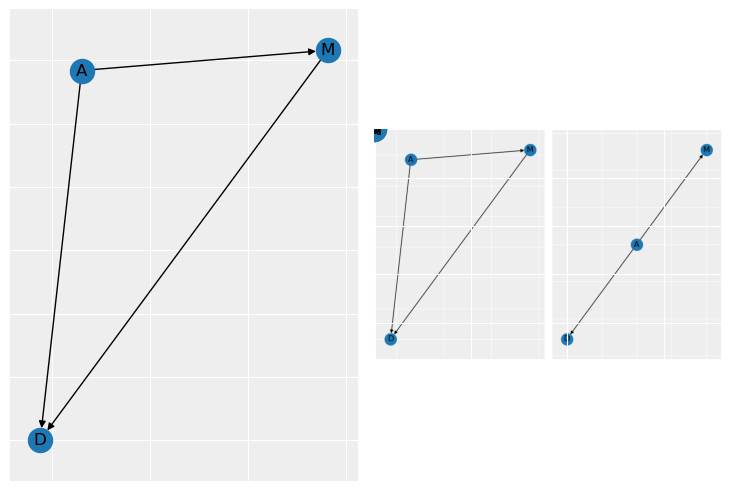

In [19]:
import networkx as nx
import matplotlib.image as mpimg


_, (ax1, ax2) = plt.subplots(1, 2)
g1 = nx.DiGraph()
g2 = nx.DiGraph()

g1.add_edges_from([('A', 'M'), ('A', 'D'), ('M', 'D')])
g2.add_edges_from([('A', 'M'), ('A', 'D')])

#plt.tight_layout()

nx.draw_networkx(g1, arrows=True, ax=ax1)
nx.draw_networkx(g2, arrows=True, ax=ax2)

plt.savefig('DAG1.png', format='PNG')

img = mpimg.imread('DAG1.png')
plt.imshow(img)

## Conditional Independence

In [20]:
df_waf['age_stan'] = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
df_waf['divorce_stan'] = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
df_waf['marriage_stan'] = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

In [21]:
df_waf[['age_stan', 'marriage_stan', 'divorce_stan']].cov()

,age_stan,marriage_stan,divorce_stan
age_stan,1.000000,-0.721096,-0.597239
marriage_stan,-0.721096,1.000000,0.373731
divorce_stan,-0.597239,0.373731,1.000000


<AxesSubplot:xlabel='marriage_stan', ylabel='divorce_stan'>

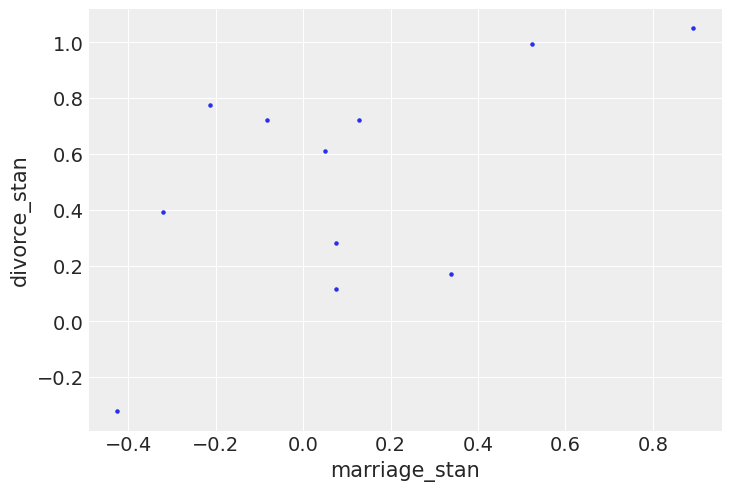

In [22]:
df_waf[(df_waf['age_stan'] >= -0.3) & 
       (df_waf['age_stan'] <= 0.0)][['marriage_stan', 
                                     'divorce_stan']].plot.scatter(x='marriage_stan', 
                                                                   y='divorce_stan', 
                                                                   marker='.')

## Multiple Regression Model

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i + \beta_M \cdot M_i\\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.10

In [23]:
with pm.Model() as m_5_3:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', alpha + beta_A * df_waf['age_stan'] + beta_M * df_waf['marriage_stan'])
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_3 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


In [24]:
az.summary(trace_5_3, var_names=['alpha', 'beta_A', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.102,-0.166,0.161,0.001,0.001,16832.0,9191.0,16836.0,12957.0,1.0
beta_A,-0.607,0.157,-0.867,-0.364,0.001,0.001,12468.0,12355.0,12470.0,13544.0,1.0
beta_M,-0.060,0.157,-0.308,0.193,0.001,0.001,12184.0,11712.0,12179.0,13342.0,1.0
sigma,0.826,0.087,0.691,0.960,0.001,0.001,14556.0,14556.0,14043.0,10578.0,1.0


In [25]:
df_tr_5_3 = pm.trace_to_dataframe(trace_5_3)
df_tr_5_3.head()

,alpha,beta_A,beta_M,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.000110,-0.709577,0.024928,0.853190,0.430884,0.526009,0.146256,1.042147,-0.432190,0.224316,...,0.259057,0.482690,0.496473,1.633719,-0.506968,-0.194773,0.096419,0.615182,-0.159376,1.127427
1,0.115790,-0.423803,0.086065,0.973388,0.374686,0.540199,0.206563,0.855965,-0.161410,0.313157,...,0.270186,0.390635,0.438224,1.269260,-0.256673,0.006628,0.197412,0.522242,-0.034077,0.987486
2,0.146008,-0.296999,0.313126,0.783099,0.333166,0.835240,0.222003,1.083153,-0.115750,0.509714,...,0.253276,0.291090,0.464229,1.585800,-0.362239,0.095202,0.288813,0.569705,-0.152991,1.461557
3,0.042818,-0.102776,0.249229,0.792807,0.110774,0.499650,0.076015,0.600276,-0.085374,0.294272,...,0.079419,0.066540,0.204348,0.892911,-0.270819,0.039555,0.139936,0.266812,-0.168736,0.890718
4,-0.022829,-0.485440,0.224552,1.045888,0.276573,0.658533,0.087315,1.033491,-0.373977,0.315550,...,0.153558,0.268307,0.392470,1.613032,-0.572649,-0.135065,0.113318,0.511926,-0.291144,1.326763


## Comparison of the $\beta_M$ and $\beta_A$ values from three models

In [26]:
summary_1 = az.summary(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'], hdi_prob=0.89)
summary_2 = az.summary(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'], hdi_prob=0.89)
summary_3 = az.summary(trace_5_3, var_names=['alpha', 'beta_A', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less 

In [27]:
type(summary_1)

pandas.core.frame.DataFrame

In [28]:
summary_1.loc['beta_A', :]

mean            -0.566
sd               0.116
hdi_5.5%        -0.747
hdi_94.5%       -0.377
mcse_mean        0.001
mcse_sd          0.001
ess_mean     22915.000
ess_sd       22074.000
ess_bulk     22978.000
ess_tail     14091.000
r_hat            1.000
Name: beta_A, dtype: float64

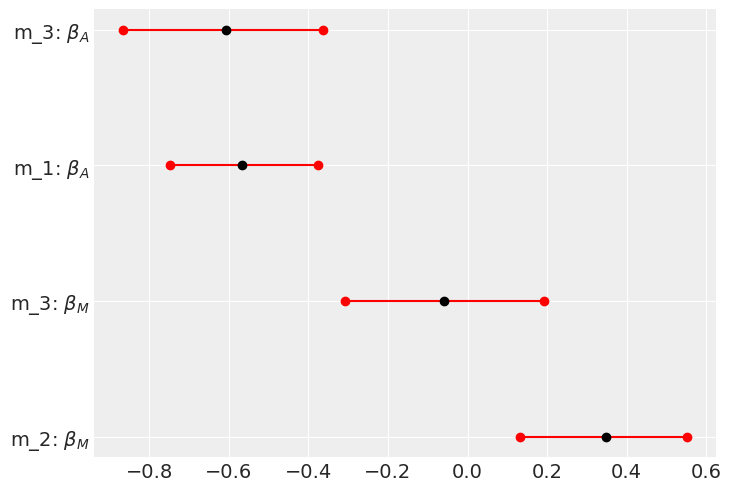

In [29]:
# Do the plots manually!

summary_list = [(summary_2, 'beta_M', 1), 
                (summary_3, 'beta_M', 2), 
                (summary_1, 'beta_A', 3),  
                (summary_3, 'beta_A', 4)]

_, ax = plt.subplots(1, 1)


for summary, var, y_level in summary_list:
    lower = summary.loc[var, 'hdi_5.5%']
    upper = summary.loc[var, 'hdi_94.5%']
    mid = summary.loc[var, 'mean']

    ax.plot((lower, upper), (y_level, y_level), 'ro-')
    ax.plot((mid), (y_level), 'ko')

plt.yticks([1, 2, 3, 4], [r'm_2: $\beta_M$', r'm_3: $\beta_M$', r'm_1: $\beta_A$', r'm_3: $\beta_A$'])

plt.show()